In [1]:
import pandas as pd
import numpy as np
import os

from encoding_function import low_frequency_to_others
from sklearn.model_selection import KFold
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from catboost_function import custom_CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [2]:
def add_y(df):
    df['rank'] = df['rank'].replace(0, 6)

    target_cols = [
        '단승', '복승', '삼복승'
    ]
    for i, col in enumerate(target_cols):
        condition_target = df['rank'] <= i+1
        df.loc[condition_target, col] = 1

    df[target_cols] = df[target_cols].fillna(0)
    df.drop(['rank'], axis=1, inplace=True)
    return df

def add_y_(df):
    df['rank'] = df['rank'].replace(0, 6)

    target_cols = [
        '단승', '복승', '삼복승'
    ]
    for i, col in enumerate(target_cols):
        condition_target = df['rank'] <= i+1
        df.loc[condition_target, col] = df['rank']

    df[target_cols] = df[target_cols].fillna(0)
    df.drop(['rank'], axis=1, inplace=True)
    return df



ROOT_DIR = "data"
RANDOM_STATE = 42

train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

train['성별'] = train['성별'].map({'남': 0, '여': 1})
test['성별'] = test['성별'].map({'남': 0, '여': 1})

train = add_y(train)
test = add_y(test)

print(train.shape, test.shape)
train.head()

(58344, 46) (6528, 46)


,Race_ID,연도,회차,일차,경주번호,경기종류,번호,등급,기수,선수명,...,모터_연대율3,전탑승선수1,전탑승선수2,보트번호,보트_평균착순점,보트_연대율,특이사항,단승,복승,삼복승
0,2016_1_1_1,2016,1,1,1,플라잉,1,A1,1,정용진,...,0.0,NaN,NaN,27,0.0,0.0,NaN,0.0,0.0,1.0
1,2016_1_1_1,2016,1,1,1,플라잉,2,A1,13,김민준,...,0.0,NaN,NaN,50,0.0,0.0,NaN,1.0,1.0,1.0
2,2016_1_1_1,2016,1,1,1,플라잉,3,B2,11,김현덕,...,0.0,NaN,NaN,71,0.0,0.0,주선보류 후 출전,0.0,0.0,0.0
3,2016_1_1_1,2016,1,1,1,플라잉,4,A1,8,한종석,...,0.0,NaN,NaN,53,0.0,0.0,NaN,0.0,1.0,1.0
4,2016_1_1_1,2016,1,1,1,플라잉,5,B1,9,정재용,...,0.0,NaN,NaN,64,0.0,0.0,NaN,0.0,0.0,0.0


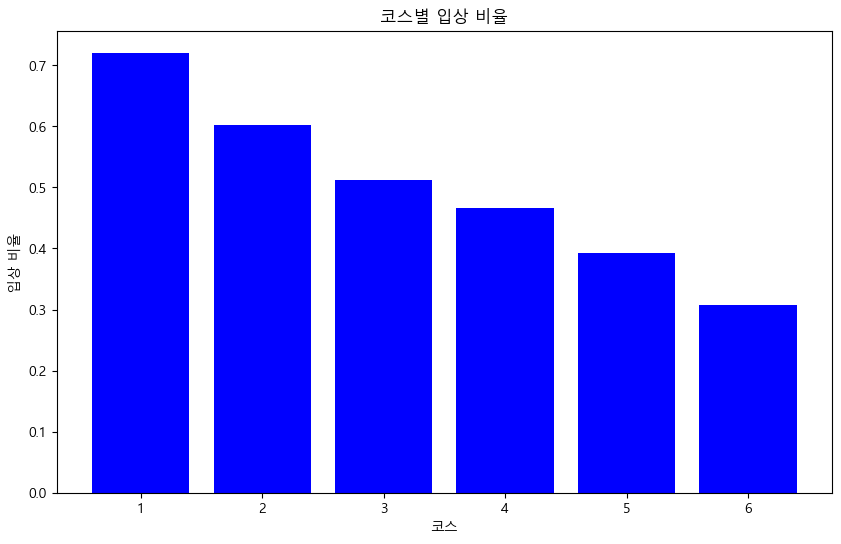

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')

condition = train['경기종류'] == '플라잉'

복승_평균 = train.loc[condition, :].groupby('번호')['삼복승'].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(복승_평균.index, 복승_평균.values, color='blue')
plt.xlabel('코스')
plt.ylabel('입상 비율')
plt.title('코스별 입상 비율')
plt.xticks(복승_평균.index)  # X축 번호 표시
plt.show()

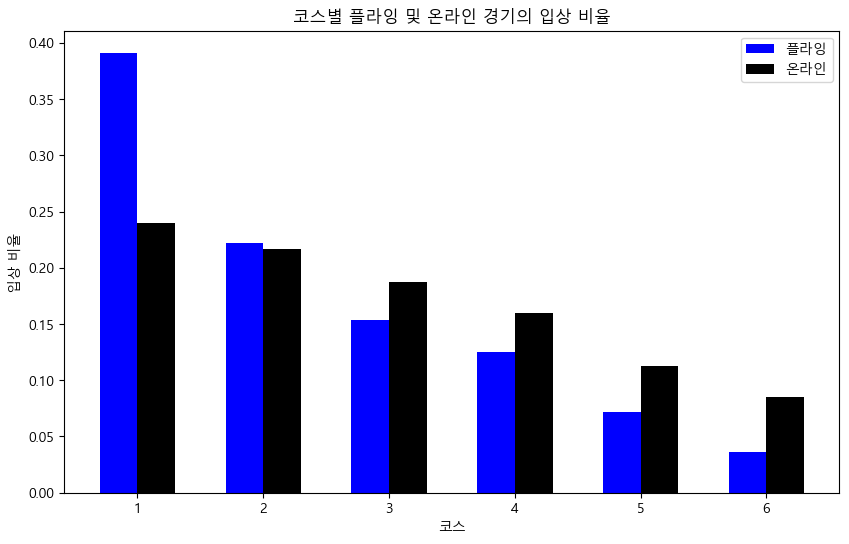

In [4]:
import matplotlib.pyplot as plt

# 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 조건 설정: 경기종류가 플라잉 또는 온라인인 경우
condition_flying = train['경기종류'] == '플라잉'
condition_online = train['경기종류'] == '온라인'

# '플라잉' 경기의 삼복승 비율 평균
삼복승_평균_플라잉 = train.loc[condition_flying, :].groupby('번호')['단승'].mean()

# '온라인' 경기의 삼복승 비율 평균
삼복승_평균_온라인 = train.loc[condition_online, :].groupby('번호')['단승'].mean()

# 시각화
plt.figure(figsize=(10, 6))

# 막대그래프 두 개 겹쳐 그리기
width = 0.3  # 막대의 너비

plt.bar(삼복승_평균_플라잉.index - width/2, 삼복승_평균_플라잉.values, width=width, label='플라잉', color='blue')
plt.bar(삼복승_평균_온라인.index + width/2, 삼복승_평균_온라인.values, width=width, label='온라인', color='black')

# 그래프 제목 및 라벨 설정
plt.xlabel('코스')
plt.ylabel('입상 비율')
plt.title('코스별 플라잉 및 온라인 경기의 입상 비율')

# X축 번호 표시
plt.xticks(삼복승_평균_플라잉.index)

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 다중공선성을 확인할 변수들만 선택
X = train[['평균사고점', '연간성적_연대율']]

# 상수항 추가 (회귀 분석을 위해 필요)
X = sm.add_constant(X)

# VIF 계산
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 값 출력
print(vif_data)

    Feature       VIF
0     const  3.427006
1     평균사고점  1.000240
2  연간성적_연대율  1.000240


In [6]:
def add_weight_penalty(df):
    weight_limit_male = 55
    weight_limit_female = 51
    df['체중'] = df['체중'].astype(float)
    
    # 중량 부과 여부 계산 (성별에 따라 다른 기준 적용)
    df['중량부과여부'] = df.apply(lambda row: 1 if (row['성별'] == 0 and row['체중'] < weight_limit_male) or
                                             (row['성별'] == 1 and row['체중'] < weight_limit_female) else 0, axis=1)

    # 부과된 중량 계산 (성별에 따라 차감된 체중을 계산)
    df['부과된중량'] = df.apply(lambda row: max(0, weight_limit_male - row['체중']) if row['성별'] == 0 else
    max(0, weight_limit_female - row['체중']), axis=1)
    
    df.drop('체중', axis=1, inplace=True)

    return df

train = add_weight_penalty(train)
test = add_weight_penalty(test)

In [7]:
def bin_age(df):
    # 나이를 5개 구간으로 나누어 bin화 (예: 0-20, 20-30, 30-40, 40-50, 50+)
    bins = [20, 30, 40, 50, 100]
    labels = ['20-30', '30-40', '40-50', '50+']

    # 나이 변수를 bin화
    df['나이'] = pd.cut(df['나이'], bins=bins, labels=labels, right=False)

    map_age = {
        '20-30':25,
        '30-40':35,
        '40-50':45,
        '50+':55,
    }
    df['나이'] = df['나이'].map(map_age)

    return df

train = bin_age(train)
test = bin_age(test)

## 사용하지 않는 feature drop

In [8]:
def drop_columns_from_datasets(df):
    drop_cols = [
        '연도', '회차', '일차', '경주번호', # 일차도 제거?
        '금일출주경주',
        '모터번호', '전탑승선수1', '전탑승선수2',
        '보트번호', '특이사항',
        'FL' # F뒤의 숫자는 현재 반기의 실격 횟수, L뒤의 숫자는 반칙횟수?
    ]

    df = df.drop(drop_cols, axis=1)

    return df


train = drop_columns_from_datasets(train)
test = drop_columns_from_datasets(test)

print(train.shape, test.shape)

(58344, 36) (6528, 36)


In [9]:
def reverse_rank_values(df_train, df_val):
    cols_to_reverse = [
        '최근6회차_평균착순점', '최근6회차_평균득점',
        '연간성적_평균착순점',
        '모터_평균착순점',
        '보트_평균착순점'
    ]
    for col in cols_to_reverse:
        max_rank = df_train[col].max()
        df_train[col] = max_rank - df_train[col]
        df_val[col] = max_rank - df_val[col]
    
        df_train[col].fillna(0, inplace=True)
        df_val[col].fillna(0, inplace=True)
    
    return df_train, df_val


train, test = reverse_rank_values(train, test)

In [10]:
import re

def extract_numbers(result):
    if isinstance(result, str):  # result가 문자열인 경우에만 처리
        return re.findall(r'-(\d+)-', result)  # -숫자- 형식에서 중간 숫자 추출
    return []  # 문자열이 아니면 빈 리스트 반환

def calculate_mean(numbers):
    numbers = [int(num) for num in numbers]  # 리스트 안의 문자열 숫자를 정수로 변환
    if len(numbers) > 0:
        return np.mean(numbers)  # 리스트가 비어있지 않으면 평균 계산
    else:
        return np.nan  # 빈 리스트인 경우 NaN 반환

def last_race_process(df_train, df_val):
    df_train['전일성적'] = df_train['전일성적'].apply(extract_numbers)  # 순위만 추출 (코스도 같이 추출?)
    df_train['전일성적'] = df_train['전일성적'].apply(calculate_mean) # 평균 계산

    df_val['전일성적'] = df_val['전일성적'].apply(extract_numbers)
    df_val['전일성적'] = df_val['전일성적'].apply(calculate_mean)

    max_rank = df_train['전일성적'].max()
    df_train['전일성적'] = max_rank - df_train['전일성적'] + 1
    df_val['전일성적'] = max_rank - df_val['전일성적'] + 1
    
    df_train['전일성적'].fillna(1, inplace=True)
    df_val['전일성적'].fillna(1, inplace=True)
    
    return df_train, df_val

train, test = last_race_process(train, test)

## 일부 숫자형 변수 변환

- 코스별 성적/경기수 분리

In [11]:
def separation_course(df):
    col_list = [
        '코스_1코스', '코스_2코스', '코스_3코스', '코스_4코스', '코스_5코스', '코스_6코스'
    ]
    for col in col_list:
        df[[f'{col[3:]}_성적', f'{col[3:]}_경기수']] = df[col].fillna('').str.split('/', expand=True)

    df.drop(col_list, axis=1, inplace=True)

    return df
        


train = separation_course(train)
test = separation_course(test)

print(train.shape, test.shape)

(58344, 42) (6528, 42)


- 코스별 성적 스무딩

In [12]:
def apply_laplace_smoothing(df, col, global_mean, alpha):
    # 경기수 0인 값이 너무 높게 나오는 경향이 있어 분모에 상수 1 추가(없애도 됨)
    encoded_value = (df[f'{col}_성적'] * df[f'{col}_경기수'] + global_mean * alpha) / (1 + df[f'{col}_경기수'] + alpha)
    df[f'{col}_성적'] = encoded_value

    return df

def laplace_smoothing_to_course(train, val=None, alpha=1):
    col_list = [
        '1코스', '2코스', '3코스', '4코스', '5코스', '6코스'
    ]
    for col in col_list:
        train[f'{col}_성적'] = train[f'{col}_성적'].astype(float)
        train[f'{col}_경기수'] = train[f'{col}_경기수'].astype(float)
        if val is not None:
            val[f'{col}_성적'] = val[f'{col}_성적'].astype(float)
            val[f'{col}_경기수'] = val[f'{col}_경기수'].astype(float)

    # Train 데이터에서 글로벌 평균 계산
    global_means = {col: train[f'{col}_성적'].mean() for col in col_list}

    for col in col_list:
        # Train 데이터에 라플라스 스무딩 적용
        train = apply_laplace_smoothing(train, col, global_means[col], alpha)
        train.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        for col in col_list:
            # Validation 데이터에 Train에서 구한 글로벌 평균으로 라플라스 스무딩 적용
            val = apply_laplace_smoothing(val, col, global_means[col], alpha)
            val.drop(f'{col}_경기수', axis=1, inplace=True)

    if val is not None:
        return train, val
    else:
        return train


train, test = laplace_smoothing_to_course(train, test, alpha=1) # 알파가 작을수록 빈도수에 가깝세, 알파가 클수록 전체 평균에 가깝게
print(train.shape, test.shape)

(58344, 36) (6528, 36)


In [13]:
def set_course_scores(df):
    # '코스_성적' 열을 초기화
    df['코스_성적'] = 0

    # '번호' 열에 따른 '코스_성적' 값 설정
    for i in range(1, 7):
        mask = df['번호'] == i
        df.loc[mask, '코스_성적'] = df.loc[mask, f'{i}코스_성적']

    # 제거할 열 목록
    drop_cols = [f'{i}코스_성적' for i in range(1, 7)]

    # 열 제거
    df = df.drop(columns=drop_cols)

    return df


from sklearn.decomposition import PCA
def apply_pca(df_train, df_val, n_components=2):
    course_cols = [f'{i}코스_성적' for i in range(1, 7)]

    pca = PCA(n_components=n_components)
    pca.fit(df_train[course_cols])

    # 훈련 데이터에 PCA 변환 적용 (transform)
    train_pca = pca.transform(df_train[course_cols])
    val_pca = pca.transform(df_val[course_cols])
    for i in range(n_components):
        col_name = f'PCA_코스성적_{i+1}'
        df_train[col_name] = train_pca[:, i]
        df_val[col_name] = val_pca[:, i]

    # 각 컴포넌트별 분산 설명 비율 출력
    # explained_variance_ratios = pca.explained_variance_ratio_
    # for i, ratio in enumerate(explained_variance_ratios):
    #     print(f"PCA Component {i+1}: {ratio:.4f} variance explained")
    
    # n_components=2가 제일 좋아보임

    return df_train, df_val


train, test = apply_pca(train, test, n_components=2)
train = set_course_scores(train)
test = set_course_scores(test)

- 최근 8경기 착순 분리

In [14]:
def split_last_eight_rank(df):
    for i in range(0, 4):
        df[f'최근{i+1}경기_착순'] = df['최근8경주_착순'].str[i]
    for j in range(5, 9):
        df[f'최근{j}경기_착순'] = df['최근8경주_착순'].str[j]
        
    df.drop('최근8경주_착순', axis=1, inplace=True)
    
    return df

# def adjust_for_top3(df):
#     col_list = [
#         '최근1경기_착순', '최근2경기_착순', '최근3경기_착순', '최근4경기_착순',
#         '최근5경기_착순', '최근6경기_착순', '최근7경기_착순', '최근8경기_착순'
#     ]
# 
#     for col in col_list:
#     # 순위가 1, 2, 3이 아닌 경우, 결측인 경우, 6으로 조정
#     # (일반화된 성능을 위해 + 3등내에 드는게 중요)
#         df[col] = df[col].apply(lambda x: x if x in ['1', '2', '3'] else '-1')
# 
#     return df

def adjust_last_eight_rank(df_train, df_val):
    col_list = [
        '최근1경기_착순', '최근2경기_착순', '최근3경기_착순', '최근4경기_착순',
        '최근5경기_착순', '최근6경기_착순', '최근7경기_착순', '최근8경기_착순'
    ]

    for col in col_list:
        df_train[col] = df_train[col].fillna(6).astype(int)
        df_val[col] = df_val[col].fillna(6).astype(int)
        
        # df_train[col] = df_train[col].replace(0, 1)  # 가끔씩 0이 있는 경우가 존재
        # df_val[col] = df_val[col].replace(0, 1)
        # 그냥 냅두는게 성능이 젤 높음

        max_rank = df_train[col].max()
        df_train[col] = max_rank - df_train[col]
        df_val[col] = max_rank - df_val[col]
    
    first_mean_cols = 3
    col_to_mean_1 = col_list[:first_mean_cols]

    df_train[f'최근{first_mean_cols}경기_평균'] = df_train[col_to_mean_1].mean(axis=1)
    df_val[f'최근{first_mean_cols}경기_평균'] = df_val[col_to_mean_1].mean(axis=1)

    df_train.drop(col_list, axis=1, inplace=True)
    df_val.drop(col_list, axis=1, inplace=True)

    return df_train, df_val


train = split_last_eight_rank(train)
# train = adjust_for_top3(train)

test = split_last_eight_rank(test)
# test = adjust_for_top3(test)

train, test = adjust_last_eight_rank(train, test)

print(train.shape, test.shape)

(58344, 33) (6528, 33)


In [15]:
def encode_categorical_features(df_train, df_val, target_value='복승'):
    df_train['번호_등급'] = df_train['번호'].astype(str) + df_train['등급'].astype(str)
    df_val['번호_등급'] = df_val['번호'].astype(str) + df_val['등급'].astype(str)
    
    target_encoder = TargetEncoder(smoothing=2)
    target_encoder.fit(df_train['번호_등급'], df_train[target_value])
    
    df_train['등급'] = target_encoder.transform(df_train['번호_등급'])
    df_val['등급'] = target_encoder.transform(df_val['번호_등급'])
    
    df_train.drop('번호_등급', axis=1, inplace=True)
    df_val.drop('번호_등급', axis=1, inplace=True)
    
    train_racetype = df_train[['경기종류']].copy()
    val_racetype = df_val[['경기종류']].copy()

    train_racetype[['플라잉', '온라인']] = 0
    val_racetype[['플라잉', '온라인']] = 0
    
    train_racetype.loc[train_racetype['경기종류']=='플라잉', '플라잉'] = 1
    train_racetype.loc[train_racetype['경기종류']=='온라인', '온라인'] = 1

    val_racetype.loc[val_racetype['경기종류']=='플라잉', '플라잉'] = 1
    val_racetype.loc[val_racetype['경기종류']=='온라인', '온라인'] = 1

    train_racetype.drop('경기종류', axis=1, inplace=True)
    val_racetype.drop('경기종류', axis=1, inplace=True)
    
    df_train = pd.concat([train_racetype, df_train], axis=1)
    df_val = pd.concat([val_racetype, df_val], axis=1)
    
    df_train.drop('경기종류', axis=1, inplace=True)
    df_val.drop('경기종류', axis=1, inplace=True)
    
    return df_train, df_val

train, test = encode_categorical_features(train, test)
train

,플라잉,온라인,Race_ID,번호,등급,기수,선수명,성별,나이,최근6회차_평균착순점,...,보트_연대율,단승,복승,삼복승,중량부과여부,부과된중량,PCA_코스성적_1,PCA_코스성적_2,코스_성적,최근3경기_평균
0,1,0,2016_1_1_1,1,0.755632,1,정용진,0,45,3.33,...,0.0,0.0,0.0,1.0,0,0.0,16.574134,23.135649,72.466565,5.000000
1,1,0,2016_1_1_1,2,0.633299,13,김민준,0,25,3.83,...,0.0,1.0,1.0,1.0,0,0.0,36.239415,-14.821515,67.503244,4.666667
2,1,0,2016_1_1_1,3,0.219374,11,김현덕,0,35,6.69,...,0.0,0.0,0.0,0.0,0,0.0,-29.709277,-2.637123,15.483830,2.000000
3,1,0,2016_1_1_1,4,0.451251,8,한종석,0,35,3.14,...,0.0,0.0,1.0,1.0,0,0.0,39.980929,-28.473963,35.617032,4.666667
4,1,0,2016_1_1_1,5,0.181429,9,정재용,0,35,5.94,...,0.0,0.0,0.0,0.0,0,0.0,-17.803091,3.856657,3.421800,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58339,1,0,2023_52_2_17,2,0.373120,1,김국흠,0,55,5.17,...,29.4,0.0,0.0,1.0,0,0.0,-23.509572,24.573374,5.746564,1.333333
58340,1,0,2023_52_2_17,3,0.388318,7,배혜민,0,45,4.21,...,32.1,0.0,0.0,0.0,0,0.0,29.011377,5.689561,36.807518,4.000000
58341,1,0,2023_52_2_17,4,0.324412,12,김인혜,1,35,4.26,...,26.1,0.0,1.0,1.0,0,0.0,18.544591,27.481776,15.950548,2.333333
58342,1,0,2023_52_2_17,5,0.142238,15,엄광호,0,35,6.56,...,30.7,0.0,0.0,0.0,0,0.0,-42.750123,-3.619043,3.421800,0.666667


## 범주형 변수 확인


In [16]:
def cal_cat_cols(train, val=None):
    objective_cols = []

    # 특정 문자열이 포함된 열을 범주형 변수로 지정
    # cat_kerword_list = ['번호', '기수', '경기_착순']
    cat_kerword_list = ['번호', '경기종류', 'Race_ID']
    for col in train.columns:
        if any(sub in col for sub in cat_kerword_list):
            objective_cols.append(col)
            train[col] = train[col].astype('str')
            val[col] = val[col].astype('str')
            
    # 나머지 열에 대해 숫자형 변환 시도
    for col in train.columns:
        if col in objective_cols:
            continue  # 이미 범주형으로 처리된 열은 제외
        try:
            # 'float' 타입으로 변환 시도
            train[col] = train[col].astype('float')
            val[col] = val[col].astype('float')
        except:
            objective_cols.append(col)

    cat_features = list(set(objective_cols) - set(['rank', 'Race_ID']))
    cat_features = [feature for feature in cat_features if '단승' not in feature]
    cat_features = [feature for feature in cat_features if '복승' not in feature]
    cat_features = [feature for feature in cat_features if '삼복승' not in feature]

    return cat_features


cat_features = cal_cat_cols(train, test)
cat_features

['선수명', '번호']

## X, y 분리

In [17]:
drop_cols = [
    'Race_ID', '번호', '단승', '복승', '삼복승', '선수명', '기수', '플라잉', '온라인'
]

train_type = train[['Race_ID', '플라잉', '온라인']]  # 일차까지?
X_train = train.drop(drop_cols, axis=1)
y_train = train[['단승']]

test_type = test[['Race_ID', '플라잉', '온라인']]
X_test = test.drop(drop_cols, axis=1)
y_test = test[['단승']]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(58344, 25) (58344, 1) (6528, 25) (6528, 1)


In [18]:
def reshape_race_data(df, players_per_race=6):
    # numpy 배열로 변환
    values = df.values

    # 데이터 형태 변환 (6개의 행을 1개의 행으로)
    reshaped_values = values.reshape(-1, players_per_race * values.shape[1])

    # 새로운 컬럼 이름 생성
    columns = [f'{col}_{i+1}번선수' for i in range(players_per_race) for col in df.columns]

    # 재구성된 DataFrame 생성
    reshaped_df = pd.DataFrame(reshaped_values, columns=columns)

    return reshaped_df

X_train = reshape_race_data(X_train, players_per_race=6)
y_train = reshape_race_data(y_train, players_per_race=6)
y_train = np.array(y_train).astype(int)

X_test = reshape_race_data(X_test, players_per_race=6)
y_test = reshape_race_data(y_test, players_per_race=6)
y_test = np.array(y_test).astype(int)

train_type.drop_duplicates(inplace=True)
test_type.drop_duplicates(inplace=True)

train_type = train_type.reset_index(drop=True)
test_type = test_type.reset_index(drop=True)

X_train = pd.concat([train_type, X_train], axis=1)
X_test = pd.concat([test_type, X_test], axis=1)

X_train.drop('Race_ID', axis=1, inplace=True)
X_test.drop('Race_ID', axis=1, inplace=True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9724, 152) (9724, 6) (1088, 152) (1088, 6)


In [19]:
def low_to_others(train, val, threshold=5, is_train=True, verbose=False):
    cat_features = cal_cat_cols(train, val)
    if is_train==False:
        cat_features = list(set(cat_features) - set(['Race_ID_1번선수', 'Race_ID_2번선수', 'Race_ID_3번선수', 'Race_ID_4번선수', 'Race_ID_5번선수', 'Race_ID_6번선수']))

    for col in cat_features:
        unifier = low_frequency_to_others(threshold=threshold, verbose=verbose)
        train[col] = unifier.fit_transform(train[col])
        val[col] = unifier.transform(val[col])

    return train, val

X_train, X_test = low_to_others(X_train, X_test, threshold=5, verbose=True)

In [103]:
def all_process(train, val, target='단승', is_train=True, is_dddd=False):
    train['성별'] = train['성별'].map({'남': 0, '여': 1}) # baseline
    val['성별'] = val['성별'].map({'남': 0, '여': 1}) # 성별 mapping 남:0, 여:1
     
    train = add_y(train)
    if is_train:
        if is_dddd:
            val = add_y_(val)
        else:
            val = add_y(val)
            
    # train = add_weight_penalty(train) # 중량부과여부, 부과된 중량 추가 / 체중은 drop
    # val = add_weight_penalty(val) # 연승 정확도를 높이려면 제거

    train = bin_age(train) # 나이 binning
    val = bin_age(val)
    
    train = drop_columns_from_datasets(train)
    val = drop_columns_from_datasets(val)

    train, val = last_race_process(train, val) # 전일 성적 평균 추가

    train, val = reverse_rank_values(train, val) # 착순 관련 데이터 reverse

    train = separation_course(train) # baseline
    val = separation_course(val)

    train, val = laplace_smoothing_to_course(train, val, alpha=1)

    train, val = apply_pca(train, val, n_components=2) # 코스별 성적 pca + 해당 코스만 남김
    train = set_course_scores(train)
    val = set_course_scores(val) 
    
    train = split_last_eight_rank(train)
    
    val = split_last_eight_rank(val)

    train, val = adjust_last_eight_rank(train, val) # 최근 8경기 중 3개는 평균, 나머지 버림

    train, val = encode_categorical_features(train, val)

    if is_train:
        drop_cols = [
            'Race_ID', '번호', '단승', '복승', '삼복승', '선수명', '기수', '플라잉', '온라인',
            # '전일성적' # baseline에서는 drop해야됨
        ]
    else:
        drop_cols = [
            'Race_ID', '번호', '선수명', '기수', '플라잉', '온라인'
        ]

    train_type = train[['Race_ID', '플라잉', '온라인']]  # 일차까지? 
    val_type = val[['Race_ID', '플라잉', '온라인']]
    
    X_train = train.drop(drop_cols, axis=1)
    y_train = train[[target]]
    X_train = reshape_race_data(X_train, players_per_race=6)
    y_train = reshape_race_data(y_train, players_per_race=6)
    # y_train = np.array(y_train).astype(int)

    X_val = val.drop(drop_cols, axis=1)
    X_val = reshape_race_data(X_val, players_per_race=6)
    if is_train:
        y_val = val[[target]]
        y_val = reshape_race_data(y_val, players_per_race=6)
        # y_val = np.array(y_val).astype(int)

    train_type.drop_duplicates(inplace=True)
    val_type.drop_duplicates(inplace=True)
    
    train_type = train_type.reset_index(drop=True)
    val_type = val_type.reset_index(drop=True)
    
    X_train = pd.concat([train_type, X_train], axis=1)
    X_val = pd.concat([val_type, X_val], axis=1)
    
    X_train.drop('Race_ID', axis=1, inplace=True)
    X_val.drop('Race_ID', axis=1, inplace=True)

    X_train, X_val = low_to_others(X_train, X_val, threshold=5, is_train=is_train, verbose=False)
    
    if is_train:
        return X_train, y_train, X_val, y_val
    else:
        return X_train, y_train, X_val
    
    
def cal_y_val_for_연승(train, test):
    df_train = train.copy()
    df_test = test.copy()
    _, _, _, y_val = all_process(df_train, df_test, target='복승', is_train=True)
    
    return y_val
    
    
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

target_value = '삼복승'
seed = 42

X_train, y_train, X_test, y_test = all_process(train, test, target=target_value, is_train=True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9724, 146) (9724, 6) (1088, 146) (1088, 6)


In [21]:
X_train

,플라잉,온라인,등급_1번선수,성별_1번선수,나이_1번선수,체중_1번선수,최근6회차_평균착순점_1번선수,최근6회차_평균득점_1번선수,최근6회차_승률_1번선수,최근6회차_연대율2_1번선수,...,출주횟수_6번선수,모터_평균착순점_6번선수,모터_연대율2_6번선수,모터_연대율3_6번선수,보트_평균착순점_6번선수,보트_연대율_6번선수,PCA_코스성적_1_6번선수,PCA_코스성적_2_6번선수,코스_성적_6번선수,최근3경기_평균_6번선수
0,1.0,0.0,0.755632,0.0,44.0,56.0,3.33,3.40,40.0,40.0,...,33.0,10.00,0.0,0.0,10.00,0.0,-15.966908,-36.511023,12.682293,3.000000
1,1.0,0.0,0.755632,0.0,39.0,55.0,3.56,3.72,12.5,43.8,...,41.0,10.00,0.0,0.0,10.00,0.0,-11.700030,8.850585,1.560071,1.333333
2,1.0,0.0,0.616358,0.0,42.0,55.0,3.67,3.67,20.0,53.3,...,34.0,10.00,0.0,0.0,10.00,0.0,14.724391,-17.554835,30.577234,2.000000
3,1.0,0.0,0.526792,0.0,45.0,56.0,7.20,7.20,6.7,6.7,...,30.0,10.00,0.0,0.0,10.00,0.0,-28.204553,-8.589447,2.340106,1.333333
4,1.0,0.0,0.755632,0.0,38.0,57.0,2.11,2.17,50.0,66.7,...,23.0,10.00,0.0,0.0,10.00,0.0,-31.171677,12.920544,22.788127,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,1.0,0.0,0.526792,0.0,35.0,55.0,4.19,4.25,31.3,50.0,...,42.0,5.30,26.9,41.9,4.20,40.7,29.333144,20.813775,14.280079,2.000000
9720,1.0,0.0,0.755632,0.0,51.0,56.0,3.53,3.71,29.4,52.9,...,36.0,4.87,29.3,50.3,4.55,37.9,-34.080408,12.627854,2.005805,3.333333
9721,1.0,0.0,0.526792,0.0,39.0,57.0,5.06,5.28,16.7,22.2,...,31.0,5.14,28.9,46.0,5.41,27.6,-25.679528,-15.868776,1.755079,2.333333
9722,1.0,0.0,0.526792,0.0,48.0,62.0,6.37,6.75,6.3,12.5,...,34.0,5.22,30.5,45.6,4.53,37.7,15.242146,-26.309298,12.682293,3.666667


In [98]:
for i in range(6):
    y_i = y_train.iloc[:, i]  # i번째 레이블에 대한 y 값
    print(y_i.value_counts())

삼복승_1번선수
1.0    6797
0.0    2927
Name: count, dtype: int64
삼복승_2번선수
1.0    5809
0.0    3915
Name: count, dtype: int64
삼복승_3번선수
1.0    4971
0.0    4753
Name: count, dtype: int64
삼복승_4번선수
0.0    5178
1.0    4546
Name: count, dtype: int64
삼복승_5번선수
0.0    5830
1.0    3894
Name: count, dtype: int64
삼복승_6번선수
0.0    6569
1.0    3155
Name: count, dtype: int64


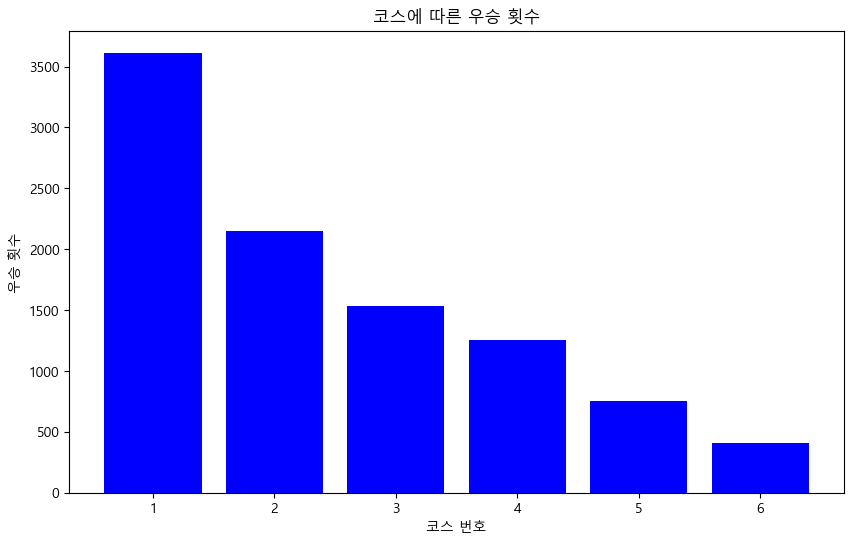

In [99]:
import matplotlib.pyplot as plt

# 데이터 준비
x = [1, 2, 3, 4, 5, 6]  # X축 값 (1번부터 6번)
y = [3614, 2152, 1537, 1258, 751, 412]  # Y축 값 (우승 비율)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='blue')

# 그래프 라벨 및 제목
plt.xlabel('코스 번호')
plt.ylabel('우승 횟수')
plt.title('코스에 따른 우승 횟수')

# X축 눈금 표시
plt.xticks(x)

# 그래프 출력
plt.show()

In [100]:
for i in range(6):
    y_i = y_train.iloc[:, i]  # i번째 레이블에 대한 y 값
    value_counts = y_i.value_counts(normalize=True)

    # 다수 클래스의 비율을 1로 고정시키고, 다른 클래스들은 상대적으로 표현
    max_class = value_counts.max()  # 다수 클래스의 비율 (가장 큰 비율)
    scaled_value_counts = value_counts / max_class  # 다수 클래스를 1로 고정

    print(f"레이블 {i+1}의 클래스 비율 (다수 클래스를 1로 고정):")
    print(scaled_value_counts)
    print("-" * 40)

레이블 1의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_1번선수
1.0    1.000000
0.0    0.430631
Name: proportion, dtype: float64
----------------------------------------
레이블 2의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_2번선수
1.0    1.000000
0.0    0.673954
Name: proportion, dtype: float64
----------------------------------------
레이블 3의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_3번선수
1.0    1.000000
0.0    0.956146
Name: proportion, dtype: float64
----------------------------------------
레이블 4의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_4번선수
0.0    1.000000
1.0    0.877945
Name: proportion, dtype: float64
----------------------------------------
레이블 5의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_5번선수
0.0    1.000000
1.0    0.667925
Name: proportion, dtype: float64
----------------------------------------
레이블 6의 클래스 비율 (다수 클래스를 1로 고정):
삼복승_6번선수
0.0    1.000000
1.0    0.480286
Name: proportion, dtype: float64
----------------------------------------


In [22]:
from ctgan import CTGAN

Xy_train = pd.concat([X_train, y_train], axis=1)
cat_features = Xy_train.columns[Xy_train.columns.str.contains(f'플라잉|온라인|성별|등급|{target_value}')].tolist()
print(cat_features)
ctgan = CTGAN(batch_size=600, discriminator_steps=1, verbose=True, epochs=300, pac=10, cuda=True)
ctgan.fit(Xy_train, discrete_columns=cat_features)

['플라잉', '온라인', '등급_1번선수', '성별_1번선수', '등급_2번선수', '성별_2번선수', '등급_3번선수', '성별_3번선수', '등급_4번선수', '성별_4번선수', '등급_5번선수', '성별_5번선수', '등급_6번선수', '성별_6번선수', '복승_1번선수', '복승_2번선수', '복승_3번선수', '복승_4번선수', '복승_5번선수', '복승_6번선수']


Gen. (-3.49) | Discrim. (0.36): 100%|██████████| 300/300 [07:22<00:00,  1.48s/it] 


In [23]:
target_cols = Xy_train.columns[Xy_train.columns.str.contains(f'{target_value}')].tolist()

new_data = ctgan.sample(6000)
condition = (new_data[target_cols[1:]].sum(axis=1) == 3) & (new_data[target_cols[0]] == 0)  # 조건
condition = (new_data[target_cols].sum(axis=1) == 2) & (new_data['플라잉'] != new_data['온라인']) # 조건
print(sum(condition))

X_ = new_data.loc[condition, :].drop(target_cols, axis=1).reset_index(drop=True)
y_ = new_data.loc[condition, :][target_cols].reset_index(drop=True)

# X_ = new_data.drop(target_cols, axis=1).reset_index(drop=True) # 조건 X
# y_ = new_data[target_cols].reset_index(drop=True)

print(X_.shape, y_.shape)

1809
(1809, 146) (1809, 6)


In [170]:
X_

,플라잉,온라인,등급_1번선수,성별_1번선수,나이_1번선수,최근6회차_평균착순점_1번선수,최근6회차_평균득점_1번선수,최근6회차_승률_1번선수,최근6회차_연대율2_1번선수,최근6회차_연대율3_1번선수,...,모터_연대율2_6번선수,모터_연대율3_6번선수,보트_평균착순점_6번선수,보트_연대율_6번선수,중량부과여부_6번선수,부과된중량_6번선수,PCA_코스성적_1_6번선수,PCA_코스성적_2_6번선수,코스_성적_6번선수,최근3경기_평균_6번선수
0,1.0,0.0,0.413511,0.0,45.548949,5.655206,5.753255,3.738940,81.763893,34.629829,...,42.906499,56.277123,4.483570,28.914367,0.001699,-0.001618,-6.455956,6.838465,17.132758,5.403851
1,0.0,1.0,0.526792,0.0,45.492113,1.829988,2.980586,1.179198,-0.111734,3.078440,...,36.480771,77.935349,4.201565,30.227478,1.066765,0.025015,-45.297790,3.637263,5.419625,3.719207
2,1.0,0.0,0.526792,1.0,45.064063,1.731181,6.885524,11.986630,11.057256,76.211962,...,39.388623,46.891328,5.553110,13.447826,0.952333,0.021607,-19.347145,-5.883115,34.104394,-0.554101
3,1.0,0.0,0.755632,0.0,45.340504,4.987739,4.776757,5.176047,2.551966,22.361105,...,31.505758,28.333486,4.548789,31.701880,1.029473,0.003991,-13.636013,6.799853,64.479306,3.273942
4,1.0,0.0,0.616358,0.0,35.300086,3.694270,4.580247,1.370188,86.582913,14.146039,...,61.388265,83.840852,4.028028,20.721601,0.961167,0.024327,-18.953331,1.590235,6.243336,0.571701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,1.0,0.0,0.616358,0.0,44.740988,5.535451,3.412049,9.964791,25.264053,44.263455,...,30.744825,32.263024,5.169840,26.925629,0.001954,-0.014288,-20.403854,61.505226,22.762146,4.582791
1897,1.0,0.0,0.413511,0.0,35.249412,4.656666,7.106566,7.525402,51.564346,37.398518,...,21.336430,25.855041,4.212872,24.053617,0.003101,0.019126,29.723034,-37.182584,1.031934,2.958998
1898,1.0,0.0,0.616358,0.0,34.691538,6.784492,3.489645,0.675583,33.575844,58.537989,...,46.687730,47.486111,4.889636,19.577603,1.019867,0.014576,54.562819,5.412098,9.284611,3.366190
1899,1.0,0.0,0.526792,0.0,34.943574,4.668116,3.584163,5.344999,15.154507,40.075521,...,24.142906,43.724706,4.671366,25.651142,0.006709,0.030180,27.493724,-6.905999,15.422226,2.735246


In [450]:
for i in range(6):
    y_i = y_.iloc[:, i]  # i번째 레이블에 대한 y 값
    print(y_i.value_counts())

단승_1번선수
0.0    5280
Name: count, dtype: int64
단승_2번선수
0.0    3991
1.0    1289
Name: count, dtype: int64
단승_3번선수
0.0    4383
1.0     897
Name: count, dtype: int64
단승_4번선수
0.0    3471
1.0    1809
Name: count, dtype: int64
단승_5번선수
0.0    4381
1.0     899
Name: count, dtype: int64
단승_6번선수
0.0    4894
1.0     386
Name: count, dtype: int64


[3614, 2152, 1537, 1258, 751, 412]
[3614, 3441, 2434, 3067, 1650, 798]


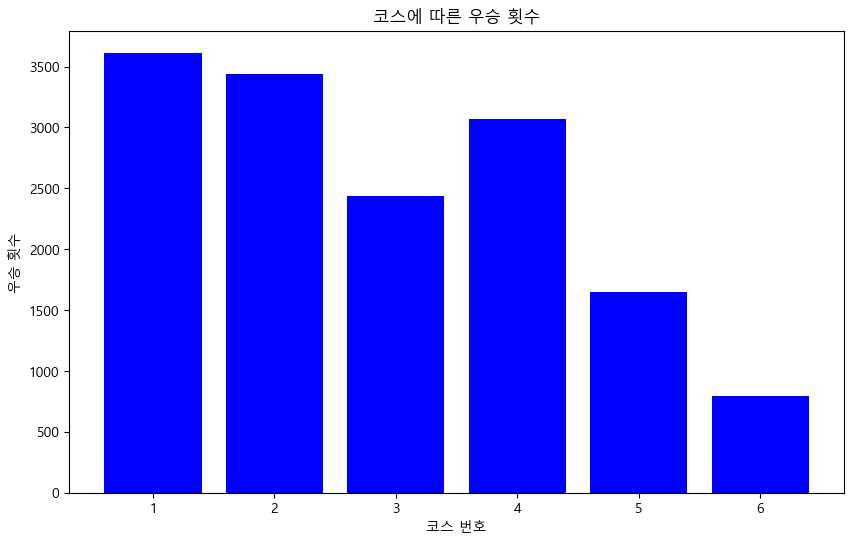

In [452]:
import matplotlib.pyplot as plt

# 데이터 준비
x = [1, 2, 3, 4, 5, 6]  # X축 값 (1번부터 6번)
y_before = [3614, 2152, 1537, 1258, 751, 412]
# y = [1521, 441, 390, 648, 336, 190] # 조건 X
y = [0, 1289, 897, 1809, 899, 386]

y_after = [a + b for a, b in zip(y_before, y)]
print(y_before)
print(y_after)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(x, y_after, color='blue')

# 그래프 라벨 및 제목
plt.xlabel('코스 번호')
plt.ylabel('우승 횟수')
plt.title('코스에 따른 우승 횟수')

# X축 눈금 표시
plt.xticks(x)

# 그래프 출력
plt.show()

In [24]:
from catboost_function import cal_params
from catboost_function import custom_CatBoostClassifier
from catboost_function import evaluate_
from rf_function import custom_randomforest, cal_rf_params

## CatBoost

In [95]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

params_list = cal_params(target_value=target_value, seed=seed)
# params_list = None # baseline

unique_race_ids = train['Race_ID'].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

models_cb = []
scores = []
for i, (train_race_ids, val_race_ids) in enumerate(kf.split(unique_race_ids)):
    train_ids = unique_race_ids[train_race_ids]
    val_ids = unique_race_ids[val_race_ids]

    train_fold = train[train['Race_ID'].isin(train_ids)].reset_index(drop=True)
    val_fold = train[train['Race_ID'].isin(val_ids)].reset_index(drop=True)

    X_train, y_train, X_val, y_val = all_process(train_fold, val_fold, target=target_value, is_train=True)

    # new_data = ctgan.sample(5000)
    # condition = (new_data[target_cols].sum(axis=1) == 2) & (new_data['플라잉'] != new_data['온라인'])
    # print(sum(condition))
    # 
    # X_tmp = new_data.loc[condition, :].drop(target_cols, axis=1).reset_index(drop=True)
    # y_tmp = new_data.loc[condition, :][target_cols].reset_index(drop=True)
    # 
    # X_train = pd.concat([X_train, X_tmp], axis=0).reset_index(drop=True)
    # y_train = pd.concat([y_train, y_tmp], axis=0).reset_index(drop=True)
    
    model = custom_CatBoostClassifier(params_list)
    cat_features = cal_cat_cols(X_train, X_val)
    if i ==0:
        print('범주형 변수: ')
        print(cat_features)
    
    model.fit(X_train, y_train)

    models_cb.append(model)
    y_pred = models_cb[i].predict_proba(X_val)
    accuracy = evaluate_(y_pred, y_val, target_value)
    scores.append(accuracy)
    print(f'folds {i+1}')
    print(f'Accuracy: {accuracy}')


print(f'최종 스코어: Avg. Accuracy of validset: {np.mean(scores)}, Std. Accuracy of validset: {np.std(scores)}')

범주형 변수: 
[]
folds 1
Accuracy: 0.2236503856041131
folds 2
Accuracy: 0.21696658097686375
folds 3
Accuracy: 0.1922879177377892
folds 4
Accuracy: 0.22005141388174806
folds 5
Accuracy: 0.2088477366255144
최종 스코어: Avg. Accuracy of validset: 0.2123608069652057, Std. Accuracy of validset: 0.011163115335631543


In [86]:
def cal_mean_feature_importance(models):
    importance_avg = None
    
    for model in models:
        importance_df = model.print_feature_importance()
        if importance_avg is None:
            importance_avg = importance_df.copy()
        else:
            importance_avg['Importance'] += importance_df['Importance']
    
    importance_avg['Importance'] /= len(models)
    
    importance_avg = importance_avg.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    return importance_avg
    
importance_avg = cal_mean_feature_importance(models_cb)
importance_avg

,Group,Importance
0,모터_연대율2,1.428193
1,전일성적,1.311317
2,모터_평균착순점,1.259628
3,모터_연대율3,1.205597
4,등급,1.176061
5,최근6회차_평균착순점,1.074817
6,PCA_코스성적_1,1.039600
7,연간성적_평균착순점,0.884353
8,최근6회차_평균득점,0.774452
9,최근6회차_연대율3,0.697879


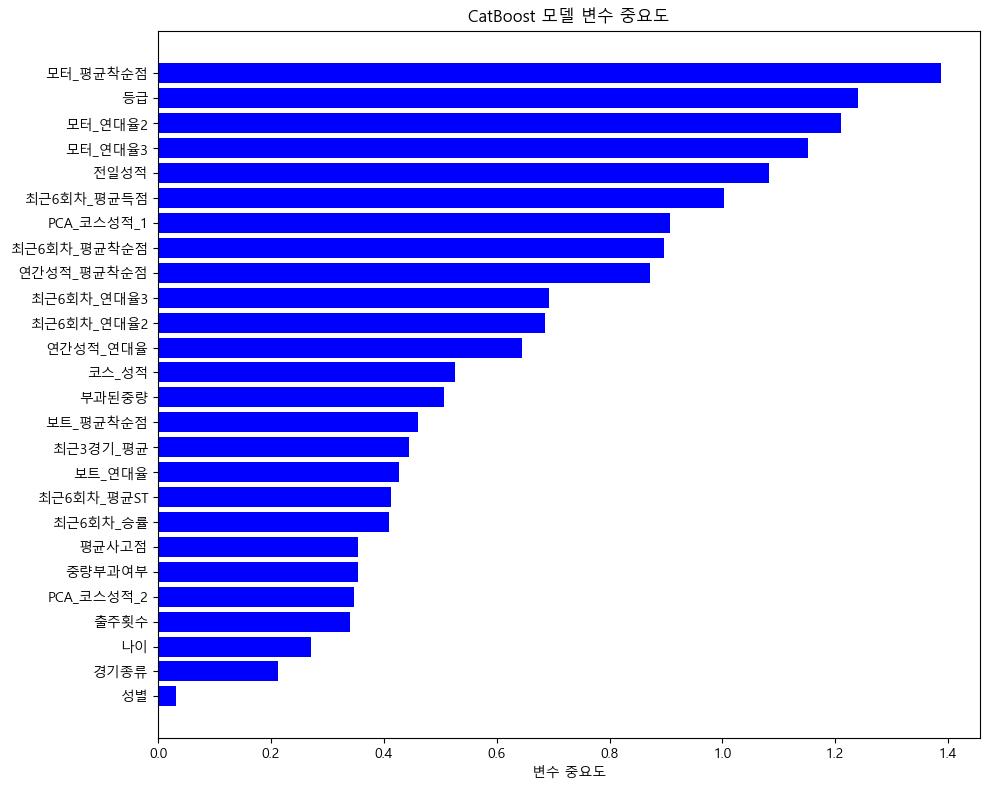

In [27]:
features = [
    '모터_평균착순점', '등급', '모터_연대율2', '모터_연대율3', '전일성적', '최근6회차_평균득점',
    'PCA_코스성적_1', '최근6회차_평균착순점', '연간성적_평균착순점', '최근6회차_연대율3',
    '최근6회차_연대율2', '연간성적_연대율', '코스_성적', '부과된중량', '보트_평균착순점',
    '최근3경기_평균', '보트_연대율', '최근6회차_평균ST', '최근6회차_승률', '평균사고점',
    '중량부과여부', 'PCA_코스성적_2', '출주횟수', '나이', '경기종류', '성별', 
]

importances = [
    1.387248, 1.240928, 1.210392, 1.151827, 1.083423, 1.003153, 0.907546, 0.896323,
    0.872303, 0.692221, 0.686133, 0.645395, 0.525885, 0.506675, 0.460124, 0.444461,
    0.426250, 0.413198, 0.408864, 0.354762, 0.353921, 0.346679, 0.340144, 0.271466,
    0.213048, 0.031426, 
]

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='blue')
plt.xlabel('변수 중요도')
plt.title('CatBoost 모델 변수 중요도')
plt.gca().invert_yaxis()  # 가장 중요한 변수를 상단에 표시
plt.tight_layout()
plt.show()

- Test 데이터

### RF

In [96]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

unique_race_ids = train['Race_ID'].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

models_rf = []
scores = []
for i, (train_race_ids, val_race_ids) in enumerate(kf.split(unique_race_ids)):
    train_ids = unique_race_ids[train_race_ids]
    val_ids = unique_race_ids[val_race_ids]

    train_fold = train[train['Race_ID'].isin(train_ids)].reset_index(drop=True)
    val_fold = train[train['Race_ID'].isin(val_ids)].reset_index(drop=True)

    X_train, y_train, X_val, y_val = all_process(train_fold, val_fold, target=target_value, is_train=True)

    # new_data = ctgan.sample(5000)
    # condition = (new_data[target_cols].sum(axis=1) == 2) & (new_data['플라잉'] != new_data['온라인'])
    # print(sum(condition))
    
    # X_tmp = new_data.loc[condition, :].drop(target_cols, axis=1).reset_index(drop=True)
    # y_tmp = new_data.loc[condition, :][target_cols].reset_index(drop=True)
    
    # X_train = pd.concat([X_train, X_tmp], axis=0).reset_index(drop=True)
    # y_train = pd.concat([y_train, y_tmp], axis=0).reset_index(drop=True)
    
    params_list = cal_rf_params()
    # params_list = None
    model = custom_randomforest(params_list)
    model.fit(X_train, y_train)

    models_rf.append(model)

    y_pred = models_rf[i].predict_proba(X_val)

    accuracy = evaluate_(y_pred, y_val, target_value)
    scores.append(accuracy)
    print(f'folds {i+1}')
    print(f'Accuracy: {accuracy}')


print(f'최종 스코어: Avg. Accuracy of validset: {np.mean(scores)}, Std. Accuracy of validset: {np.std(scores)}')

folds 1
Accuracy: 0.21131105398457584
folds 2
Accuracy: 0.20411311053984577
folds 3
Accuracy: 0.18508997429305912
folds 4
Accuracy: 0.1994858611825193
folds 5
Accuracy: 0.19958847736625515
최종 스코어: Avg. Accuracy of validset: 0.19991769547325106, Std. Accuracy of validset: 0.008573987480311887


In [29]:
importance_avg = cal_mean_feature_importance(models_rf)
importance_avg

,Group,Importance
0,PCA_코스성적_1,0.010254
1,모터_평균착순점,0.010227
2,모터_연대율2,0.009876
3,PCA_코스성적_2,0.009777
4,모터_연대율3,0.009673
5,최근6회차_평균착순점,0.008816
6,최근6회차_평균득점,0.008770
7,연간성적_평균착순점,0.008272
8,보트_평균착순점,0.007833
9,보트_연대율,0.007722


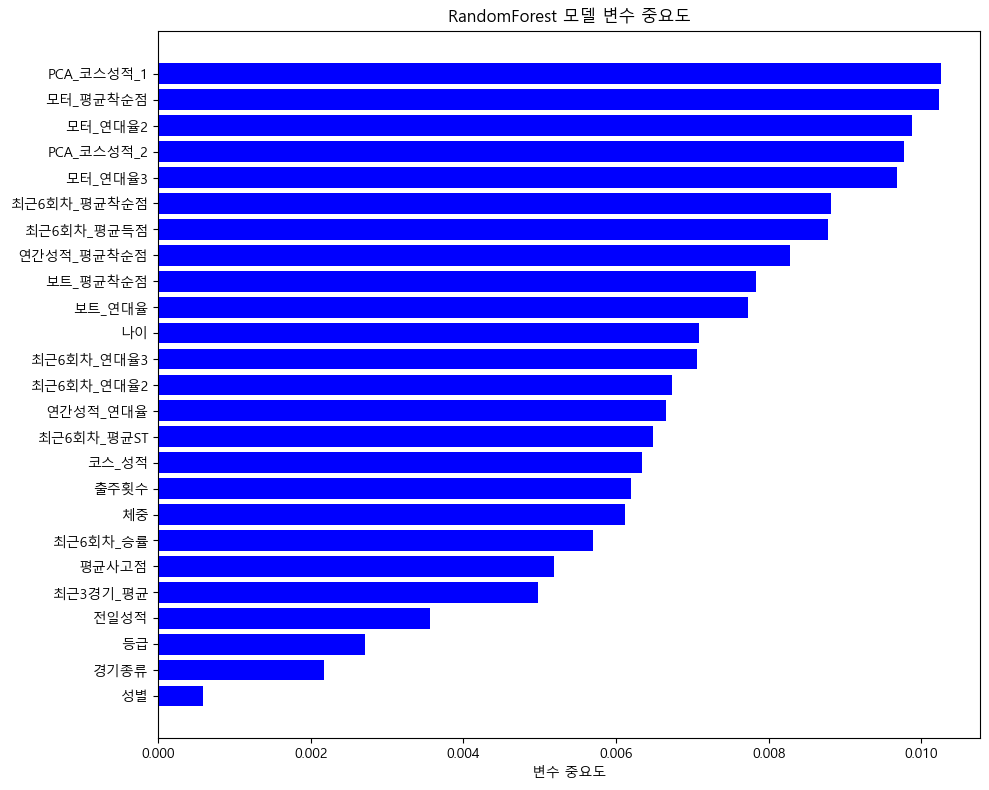

In [184]:
import matplotlib.pyplot as plt

# 변수 중요도 데이터 준비
features_rf = [
    'PCA_코스성적_1', '모터_평균착순점', '모터_연대율2', 'PCA_코스성적_2', '모터_연대율3',
    '최근6회차_평균착순점', '최근6회차_평균득점', '연간성적_평균착순점', '보트_평균착순점',
    '보트_연대율', '나이', '최근6회차_연대율3', '최근6회차_연대율2', '연간성적_연대율',
    '최근6회차_평균ST', '코스_성적', '출주횟수', '체중', '최근6회차_승률', '평균사고점',
    '최근3경기_평균', '전일성적', '등급', '경기종류', '성별'
]

importances_rf = [
    0.010254, 0.010227, 0.009876, 0.009777, 0.009673, 0.008816, 0.008770, 0.008272,
    0.007833, 0.007722, 0.007088, 0.007058, 0.006737, 0.006658, 0.006480, 0.006334,
    0.006189, 0.006117, 0.005699, 0.005184, 0.004976, 0.003558, 0.002713, 0.002172,
    0.000593
]

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(features_rf, importances_rf, color='blue')
plt.xlabel('변수 중요도')
plt.title('RandomForest 모델 변수 중요도')
plt.gca().invert_yaxis()  # 가장 중요한 변수를 상단에 표시
plt.tight_layout()
plt.show()


In [97]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

y_test_for_연승 = cal_y_val_for_연승(train, test)
y_test_for_연승 = np.array(y_test_for_연승)

In [98]:
race_id = test[['Race_ID']].copy()
race_id_unique = race_id.drop_duplicates().reset_index(drop=True)

In [99]:
unique_race_ids = train['Race_ID'].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

all_predictions_cb = []
for i, (train_race_ids, val_race_ids) in enumerate(kf.split(unique_race_ids)):
    train_ids = unique_race_ids[train_race_ids]

    train_fold = train[train['Race_ID'].isin(train_ids)].reset_index(drop=True)
    test_fold = test.copy()

    X_train, y_train, X_test, y_test = all_process(train_fold, test_fold, target=target_value, is_train=True)

    y_pred_cb = models_cb[i].predict_proba(X_test)
    all_predictions_cb.append(y_pred_cb)

mean_pred_cb = np.mean(all_predictions_cb, axis=0)
mean_pred_cb = mean_pred_cb / mean_pred_cb.sum(axis=1, keepdims=True)

y_test = np.array(y_test)
accuracy, 연승_score = evaluate_(mean_pred_cb, y_test, target_value, contain_연승=True, y_val_연승=y_test_for_연승)

print(f'최종 스코어: Accuracy of testset: {accuracy}, 연승 적중률: Accuracy of testset: {연승_score}')

최종 스코어: Accuracy of testset: 0.19025735294117646, 연승 적중률: Accuracy of testset: 0.6617647058823529


In [100]:
unique_race_ids = train['Race_ID'].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

all_predictions_rf = []
for i, (train_race_ids, val_race_ids) in enumerate(kf.split(unique_race_ids)):
    train_ids = unique_race_ids[train_race_ids]

    train_fold = train[train['Race_ID'].isin(train_ids)].reset_index(drop=True)
    test_fold = test.copy()

    X_train, y_train, X_test, y_test = all_process(train_fold, test_fold, target=target_value, is_train=True)

    y_pred_rf = models_rf[i].predict_proba(X_test)
    all_predictions_rf.append(y_pred_rf)

mean_pred_rf = np.mean(all_predictions_rf, axis=0)
mean_pred_rf = mean_pred_rf / mean_pred_rf.sum(axis=1, keepdims=True)

y_test = np.array(y_test)
accuracy, 연승_score = evaluate_(mean_pred_rf, y_test, target_value, contain_연승=True, y_val_연승=y_test_for_연승)

print(f'최종 스코어: Accuracy of testset: {accuracy}, 연승 적중률: Accuracy of testset: {연승_score}')

최종 스코어: Accuracy of testset: 0.17738970588235295, 연승 적중률: Accuracy of testset: 0.6599264705882353


In [102]:
mean_pred = (mean_pred_cb + mean_pred_cb) / 2

y_test = np.array(y_test)
accuracy, 연승_score = evaluate_(mean_pred, y_test, target_value, contain_연승=True, y_val_연승=y_test_for_연승)

print(f'최종 스코어: Accuracy of testset: {accuracy}, 연승 적중률: Accuracy of testset: {연승_score}')

최종 스코어: Accuracy of testset: 0.19025735294117646, 연승 적중률: Accuracy of testset: 0.6617647058823529


In [51]:
pd.DataFrame(mean_pred, columns=['1번', '2번', '3번', '4번', '5번', '6번'])

,1번,2번,3번,4번,5번,6번
0,0.205267,0.194739,0.149149,0.148807,0.144091,0.157947
1,0.214240,0.173929,0.205169,0.137702,0.199915,0.069044
2,0.245593,0.188804,0.206930,0.194682,0.085360,0.078631
3,0.278139,0.234391,0.156968,0.133412,0.147552,0.049538
4,0.220221,0.167364,0.210315,0.170061,0.117544,0.114495
...,...,...,...,...,...,...
1083,0.202970,0.219457,0.121012,0.163724,0.127348,0.165489
1084,0.253238,0.170122,0.171315,0.267010,0.058082,0.080232
1085,0.264610,0.142049,0.210861,0.160508,0.113589,0.108384
1086,0.226473,0.226303,0.202866,0.164382,0.100820,0.079156


In [52]:
mean_pred_복승 = pd.concat([race_id_unique, pd.DataFrame(mean_pred, columns=['1번', '2번', '3번', '4번', '5번', '6번'])], axis=1)
mean_pred_복승

,Race_ID,1번,2번,3번,4번,5번,6번
0,2024_1_1_1,0.205267,0.194739,0.149149,0.148807,0.144091,0.157947
1,2024_1_1_2,0.214240,0.173929,0.205169,0.137702,0.199915,0.069044
2,2024_1_1_3,0.245593,0.188804,0.206930,0.194682,0.085360,0.078631
3,2024_1_1_4,0.278139,0.234391,0.156968,0.133412,0.147552,0.049538
4,2024_1_1_5,0.220221,0.167364,0.210315,0.170061,0.117544,0.114495
...,...,...,...,...,...,...,...
1083,2024_37_1_11,0.202970,0.219457,0.121012,0.163724,0.127348,0.165489
1084,2024_37_1_12,0.253238,0.170122,0.171315,0.267010,0.058082,0.080232
1085,2024_37_1_14,0.264610,0.142049,0.210861,0.160508,0.113589,0.108384
1086,2024_37_1_16,0.226473,0.226303,0.202866,0.164382,0.100820,0.079156


In [53]:
mean_pred_복승.to_csv(f'./복승_확률값.csv', index=False, encoding='utf-8-sig')

In [54]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

X_train, y_train, X_test, y_test = all_process(train, test, target='삼복승', is_train=True, is_dddd=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9724, 146) (9724, 6) (1088, 146) (1088, 6)


In [55]:
y_test

,삼복승_1번선수,삼복승_2번선수,삼복승_3번선수,삼복승_4번선수,삼복승_5번선수,삼복승_6번선수
0,0.0,3.0,2.0,0.0,1.0,0.0
1,2.0,0.0,1.0,0.0,0.0,3.0
2,0.0,2.0,3.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,2.0,3.0
4,1.0,0.0,0.0,2.0,0.0,3.0
...,...,...,...,...,...,...
1083,1.0,0.0,0.0,3.0,2.0,0.0
1084,2.0,0.0,0.0,1.0,3.0,0.0
1085,1.0,2.0,0.0,0.0,0.0,3.0
1086,2.0,0.0,1.0,0.0,0.0,3.0


In [56]:
y_test.to_csv(f'./삼복승_순위값.csv', index=False, encoding='utf-8-sig')

- Base_line_단승:  Accuracy of testset: 0.4532940019665683
- 

## 복승
- 최종 스코어: Accuracy of testset: 0.2693798449612403, 연승 적중률: Accuracy of testset: 0.6821705426356589 (범주형 변수 변환(등급, 나이))
- 최종 스코어: Accuracy of testset: 0.2751937984496124, 연승 적중률: Accuracy of testset: 0.6724806201550387 (범주형 변수 변환(등급, 나이)) 파라미터 optuna로 조정

- RF
- 최종 스코어: Accuracy of testset: 0.2761627906976744, 연승 적중률: Accuracy of testset: 0.6560077519379846

- 앙상블
- 최종 스코어: Accuracy of testset: 0.2800387596899225, 연승 적중률: Accuracy of testset: 0.6666666666666666


### 삼복승
- Base_line_삼복승: Accuracy of testset: 0.18682399213372664

# 실제 경기 예측

In [122]:
from crawlling_entry import crawl_race_entries

연도 = 2024
회차 = 37
일차 = 3
sub = crawl_race_entries(연도, 회차, 일차)
for col in sub.columns:
    try:
        sub[col] = sub[col].astype(float)
    except:
        continue

day_ord = sub[['경주번호']].astype(int)
day_ord.drop_duplicates(inplace=True)
day_ord['경주번호'] = day_ord['경주번호'].astype(str) + '경기'

sub['Race_ID'] = sub.apply(lambda row: f"{int(row['연도'])}_{int(row['회차'])}_{int(row['일차'])}_{int(row['경주번호'])}", axis=1)
sub

Skipping race: 2024 37 3 1 due to error: list index out of range
Skipping race: 2024 37 3 16 due to error: list index out of range


,연도,회차,일차,경주번호,경기종류,번호,등급,기수,선수명,성별,...,모터_평균착순점,모터_연대율2,모터_연대율3,전탑승선수1,전탑승선수2,보트번호,보트_평균착순점,보트_연대율,특이사항,Race_ID
0,2024.0,37.0,3.0,2.0,플라잉,1.0,B2,13.0,김도휘,남,...,7.41,62.1,75.9,김민준/116,주은석/1114,25.0,6.11,44.4,,2024_37_3_2
1,2024.0,37.0,3.0,2.0,플라잉,2.0,A1,6.0,안지민,여,...,4.51,28.6,42.9,이종인/463,홍진수/145,101.0,5.24,35.1,F 후 출전,2024_37_3_2
2,2024.0,37.0,3.0,2.0,플라잉,3.0,A2,2.0,이재학,남,...,5.70,39.4,54.5,박진서/464,이승일/331,5.0,5.94,43.8,,2024_37_3_2
3,2024.0,37.0,3.0,2.0,플라잉,4.0,B2,5.0,주은석,남,...,5.38,35.1,48.6,김응선/644,신동길/664,26.0,5.18,36.4,,2024_37_3_2
4,2024.0,37.0,3.0,2.0,플라잉,5.0,A2,1.0,김창규,남,...,5.68,40.0,60.0,윤상선/356,주은석/12,9.0,6.53,56.3,,2024_37_3_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024.0,37.0,3.0,17.0,온라인,2.0,A2,2.0,최재원,남,...,4.92,24.0,48.0,박종덕/312,임 건/43,82.0,4.50,11.1,부상 후 출전,2024_37_3_17
86,2024.0,37.0,3.0,17.0,온라인,3.0,A2,8.0,전두식,남,...,5.26,28.6,60.0,김영민/313,이응석/63,108.0,4.63,25.0,,2024_37_3_17
87,2024.0,37.0,3.0,17.0,온라인,4.0,B1,9.0,홍기철,남,...,5.68,45.9,59.5,반혜진/621,박상현/225,11.0,5.62,44.1,,2024_37_3_17
88,2024.0,37.0,3.0,17.0,온라인,5.0,A1,7.0,심상철,남,...,6.22,34.4,75.0,박정아/13,김도휘/132,1.0,6.17,45.7,,2024_37_3_17


In [123]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))

unique_race_ids = train['Race_ID'].unique()
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

all_predictions_cb = []
all_predictions_rf = []
for i, (train_race_ids, val_race_ids) in enumerate(kf.split(unique_race_ids)):
    train_ids = unique_race_ids[train_race_ids]

    train_fold = train[train['Race_ID'].isin(train_ids)].reset_index(drop=True)
    test_fold = sub.copy()

    X_train, y_train, X_test = all_process(train_fold, test_fold, target=target_value, is_train=False)

    y_pred_cb = models_cb[i].predict_proba(X_test)
    all_predictions_cb.append(y_pred_cb)

    y_pred_rf = models_rf[i].predict_proba(X_test)
    all_predictions_rf.append(y_pred_rf)

mean_pred_cb = np.mean(all_predictions_cb, axis=0)
mean_pred_cb = mean_pred_cb / mean_pred_cb.sum(axis=1, keepdims=True)

mean_pred_rf = np.mean(all_predictions_rf, axis=0)
mean_pred_rf = mean_pred_rf / mean_pred_rf.sum(axis=1, keepdims=True)

mean_pred = (mean_pred_cb + mean_pred_cb) / 2

mean_pred_df = pd.DataFrame(mean_pred)
mean_pred_df.index = day_ord['경주번호'].values
mean_pred_df.columns = [f"{i+1}번" for i in range(mean_pred_df.shape[1])]
mean_pred_df = mean_pred_df.div(mean_pred_df.sum(axis=1), axis=0)
mean_pred_df

,1번,2번,3번,4번,5번,6번
2경기,0.217676,0.174161,0.197198,0.184503,0.134171,0.092291
3경기,0.201021,0.208700,0.153137,0.197920,0.123822,0.115401
4경기,0.211277,0.182329,0.177653,0.102249,0.135980,0.190513
5경기,0.211025,0.185863,0.204171,0.127886,0.159749,0.111306
6경기,0.219416,0.186302,0.166653,0.178286,0.153418,0.095925
7경기,0.152358,0.175010,0.159281,0.168351,0.166207,0.178792
8경기,0.207881,0.192094,0.195660,0.099494,0.131729,0.173142
9경기,0.203777,0.207483,0.205312,0.166487,0.160604,0.056338
10경기,0.210198,0.211750,0.187530,0.161792,0.194496,0.034234
11경기,0.238887,0.191757,0.174321,0.221174,0.125510,0.048350


In [124]:
mean_pred_df.to_csv(f'./backtesting/{연도}_{회차}_{일차}_{target_value}_mean.csv', index=True, encoding='utf-8-sig')

In [83]:
mean_pred_cb = pd.DataFrame(mean_pred_cb)
mean_pred_cb.index = day_ord['경주번호'].values
mean_pred_cb.columns = [f"{i+1}번" for i in range(mean_pred_cb.shape[1])]

mean_pred_rf = pd.DataFrame(mean_pred_rf)
mean_pred_rf.index = day_ord['경주번호'].values
mean_pred_rf.columns = [f"{i+1}번" for i in range(mean_pred_rf.shape[1])]

mean_pred_cb.to_csv(f'./backtesting/{연도}_{회차}_{일차}_{target_value}_CB.csv', index=True, encoding='utf-8-sig')
mean_pred_rf.to_csv(f'./backtesting/{연도}_{회차}_{일차}_{target_value}_RF.csv', index=True, encoding='utf-8-sig')